# Выполнил Лялин И.Е. ББМО-02-24

1) Загрузка обученной модели и данных MNIS, и проверка её на точность

 Загружаем предварительно обученную модель для распознавания рукописных цифр и проверяет ее точность на тестовом наборе данных MNIST.



In [15]:
# Импорт необходимых библиотек и модулей
import tensorflow as tf  # Основная библиотека для работы с нейронными сетями
from tensorflow.keras.datasets import mnist  # Загрузка набора данных MNIST
from tensorflow.keras.utils import to_categorical  # Для преобразования меток в one-hot формат

# Загрузка тестовых данных MNIST
# Функция load_data() возвращает два кортежа: (train_images, train_labels), (test_images, test_labels)
# Здесь мы используем символ подчеркивания _ для игнорирования ненужных тренировочных данных
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных: преобразование значений пикселей из диапазона [0, 255] в [0, 1]
# Это улучшает сходимость и стабильность обучения нейронной сети
test_images = test_images / 255.0

# Преобразование меток в формат one-hot encoding
# Например, цифра 3 превращается в [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
# num_classes=10 указывает, что у нас 10 классов (цифры от 0 до 9)
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка предварительно обученной модели из файла
# 'pr2_model.h5' - файл в формате HDF5, содержащий архитектуру и веса модели
model = tf.keras.models.load_model('pr2_model.h5')

# Проверка точности модели на обычных (не модифицированных) данных
# evaluate() возвращает значение функции потерь и метрики точности
test_loss, test_acc = model.evaluate(test_images, test_labels)

# Вывод точности модели в удобочитаемом формате
# f-строка позволяет вставлять значения переменных непосредственно в текст
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9715 - loss: 0.0940
Test accuracy on clean images: 0.9760000109672546


2) Импорт необходимых библиотек

In [16]:
# Установка библиотеки foolbox - мощного инструмента для атак на нейронные сети (adversarial attacks)
!pip install foolbox

# Импорт установленной библиотеки foolbox
import foolbox as fb

# Импорт библиотеки numpy для работы с многомерными массивами и математическими операциями
import numpy as np

# Импорт библиотеки matplotlib.pyplot для визуализации и построения графиков
import matplotlib.pyplot as plt

3) Выполнение атаки Carlini-Wagner

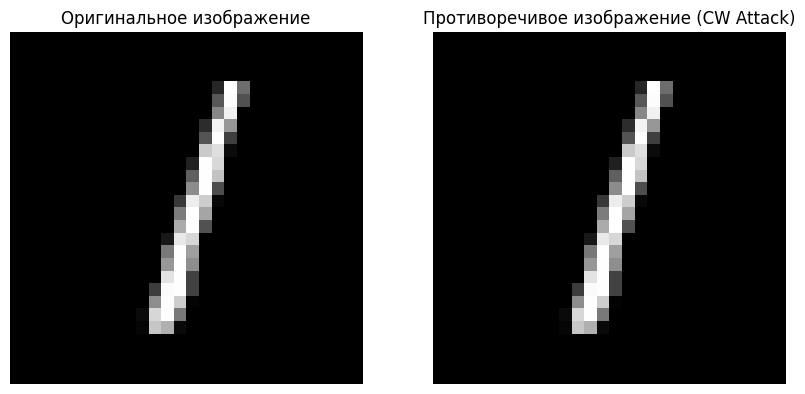

In [24]:
# Инициализация Foolbox модели на основе нашей TensorFlow модели
# bounds=(0, 1) указывает диапазон значений пикселей (после нормализации)
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор конкретного изображения для атаки (третье изображение из тестового набора)
# [None, ...] добавляет размерность батча (преобразует из (28,28) в (1,28,28))
image = tf.convert_to_tensor(test_images[2], dtype=tf.float32)[None, ...]

# Получение истинной метки для первого изображения (используется test_labels[0])
# np.argmax() преобразует one-hot encoding обратно в числовую метку
label = np.argmax(test_labels[0])

# Преобразование метки в тензор TensorFlow с правильным типом данных
label_tensor = tf.convert_to_tensor(label, dtype=tf.int64)

# Создание атаки Carlini-Wagner (мощная и эффективная L2-атака)
# steps=3 - количество итераций оптимизации (меньше = быстрее, но менее точно)
attack = fb.attacks.L2CarliniWagnerAttack(steps=3)

# Проверка доступности GPU для ускорения вычислений
tf.config.list_physical_devices('GPU')

# Выполнение атаки: создание adversarial example
# epsilons=0.1 - максимально допустимое отклонение от оригинала (в L2-норме)
adversarial_image = attack(fmodel, image, label_tensor[None], epsilons=0.1)

# Вывод результатов - создание визуального сравнения
plt.figure(figsize=(10, 5))  # Создание фигуры размером 10x5 дюймов


plt.subplot(1, 2, 1)  # Создание подграфика 1x2, позиция 1
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")  # Отображение изображения в grayscale
plt.axis('off')  # Отключение осей

plt.subplot(1, 2, 2)  # Создание подграфика 1x2, позиция 2
plt.title("Противоречивое изображение (CW Attack)")
# adversarial_image[0][0] - извлечение конкретного adversarial example
plt.imshow(adversarial_image[0][0].numpy(), cmap="gray")
plt.axis('off')  # Отключение осей

plt.show()

4) Оценка модели на противоречивых примерах


len(test_images) // 10 - обрабатываем только 10% данных (600 вместо 6000) для экономии времени

attack(fmodel, image, label[None], epsilons=0.1) - возвращает три значения:

advs - adversarial examples

_ - отброшенные clipped adversarials (игнорируем)

success - флаги успешности атаки

test_labels[:1000] - берем первые 1000 меток, так как мы создали 1000 adversarial examples

In [11]:
adversarial_images = []  # Создание пустого списка для хранения adversarial examples

# Обработка изображений в цикле
for i in range(len(test_images) // 10):  # Ограничиваем выборку в 10 раз для ускорения выполнения
    # Подготовка изображения: преобразование в тензор и добавление размерности батча
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]

    # Получение истинной метки (преобразование из one-hot в числовой формат)
    label = np.argmax(test_labels[i])

    # Преобразование метки в тензор TensorFlow
    label = tf.convert_to_tensor(label, dtype=tf.int64)

    # Атака на изображение: генерация adversarial example
    # attack() возвращает кортеж: (adversarial_images, clipped_adversarials, success_flags)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)

    # Добавление полученного adversarial example в список
    adversarial_images.append(advs)

# Конвертация списка в массив с правильной формой
# tf.concat объединяет все тензоры вдоль axis=0 (по батчу)
adversarial_images = tf.concat(adversarial_images, axis=0)

# Убедитесь, что test_labels имеют соответствующее количество меток
# Оцениваем модель на adversarial examples (первые 1000 меток соответствуют 1000 изображений)
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:1000])

print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0879 - loss: 2.4017
Accuracy on adversarial examples (CW attack): 0.0820000022649765


# Вывод: Атака CW оказалось крайне эффективной, т.к. точность модели снизилась до 8.2%